<a href="https://colab.research.google.com/github/ggwnsghgg/Exchange_rate_prediction_Project/blob/main/LSTM_%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%98%88%EC%B8%A1_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# 파일 업로드 기능 실행 
from google.colab import files
uploaded = files.upload() 

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving aptsellindex_gangnamgu.csv to aptsellindex_gangnamgu (2).csv
User uploaded file "aptsellindex_gangnamgu.csv" with length 4429 bytes


In [2]:
print(pd.__version__)
# 한글이 깨져서 encodin 지정함 
df = pd.read_csv('aptsellindex_gangnamgu.csv', parse_dates =["date"], index_col ="date", engine='python',encoding='euc-kr', dtype={'trade_price_idx_value':'float'}) 
  
df.head()

1.1.5


,trade_price_idx_value
date,
2006-01-01,74.2
2006-02-01,75.8
2006-03-01,78.1
2006-04-01,81.4
2006-05-01,83.6


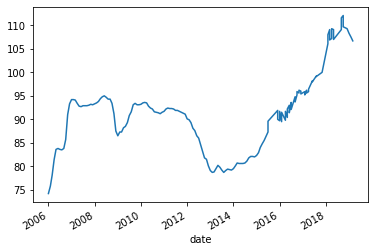

In [3]:
df['trade_price_idx_value'].plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2006-01-01 to 2019-03-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trade_price_idx_value  165 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [5]:
df

,trade_price_idx_value
date,
2006-01-01,74.2
2006-02-01,75.8
2006-03-01,78.1
2006-04-01,81.4
2006-05-01,83.6
...,...
2018-10-01,109.7
2018-12-01,109.3
2019-01-01,108.3


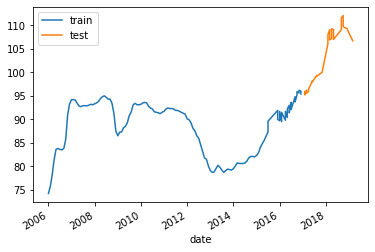

In [6]:
# 그 이후 데이터를 테스트셋으로 한다.
split_date = pd.Timestamp('01-01-2017')


train = df.loc[:split_date, ['trade_price_idx_value']]
test = df.loc[split_date:, ['trade_price_idx_value']]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.        ],
       [0.07272727],
       [0.17727273],
       [0.32727273],
       [0.42727273],
       [0.43636364],
       [0.42727273],
       [0.42272727],
       [0.43636364],
       [0.52272727],
       [0.76363636],
       [0.86818182],
       [0.90909091],
       [0.90909091],
       [0.90454545],
       [0.87272727],
       [0.84545455],
       [0.84090909],
       [0.85      ],
       [0.85      ],
       [0.85      ],
       [0.85454545],
       [0.86363636],
       [0.85909091],
       [0.86818182],
       [0.87727273],
       [0.89090909],
       [0.91818182],
       [0.93636364],
       [0.94545455],
       [0.93181818],
       [0.91363636],
       [0.91363636],
       [0.87272727],
       [0.77272727],
       [0.60454545],
       [0.55909091],
       [0.59545455],
       [0.59545455],
       [0.63636364],
       [0.65      ],
       [0.68636364],
       [0.75454545],
       [0.79090909],
       [0.85909091],
       [0.87272727],
       [0.85909091],
       [0.859

In [9]:
train_sc_df = pd.DataFrame(train_sc, columns=['trade_price_idx_value'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['trade_price_idx_value'], index=test.index)
train_sc_df.head()

,trade_price_idx_value
date,
2006-01-01,0.000000
2006-02-01,0.072727
2006-03-01,0.177273
2006-04-01,0.327273
2006-05-01,0.427273


In [10]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['trade_price_idx_value'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['trade_price_idx_value'].shift(s)

train_sc_df.head(13)

,trade_price_idx_value,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,,
2006-01-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-01,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-01,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-01,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN
2006-09-01,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN


In [11]:
X_train = train_sc_df.dropna().drop('trade_price_idx_value', axis=1)
y_train = train_sc_df.dropna()[['trade_price_idx_value']]

X_test = test_sc_df.dropna().drop('trade_price_idx_value', axis=1)
y_test = test_sc_df.dropna()[['trade_price_idx_value']]



X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,
2007-01-01,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000
2007-02-01,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727
2007-03-01,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273
2007-04-01,0.904545,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273
2007-05-01,0.872727,0.904545,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273


In [12]:
y_train.head()

,trade_price_idx_value
date,
2007-01-01,0.909091
2007-02-01,0.909091
2007-03-01,0.904545
2007-04-01,0.872727
2007-05-01,0.845455


In [13]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
#print(X_train)
print(y_train.shape)
#print(y_train)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(125, 12)
(125, 1)


In [14]:

X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(125, 12, 1)
[[[0.86818182]
  [0.76363636]
  [0.52272727]
  ...
  [0.17727273]
  [0.07272727]
  [0.        ]]

 [[0.90909091]
  [0.86818182]
  [0.76363636]
  ...
  [0.32727273]
  [0.17727273]
  [0.07272727]]

 [[0.90909091]
  [0.90909091]
  [0.86818182]
  ...
  [0.42727273]
  [0.32727273]
  [0.17727273]]

 ...

 [[0.97272727]
  [0.98636364]
  [0.95454545]
  ...
  [0.81818182]
  [0.73636364]
  [0.79545455]]

 [[1.        ]
  [0.97272727]
  [0.98636364]
  ...
  [0.85454545]
  [0.81818182]
  [0.73636364]]

 [[0.99090909]
  [1.        ]
  [0.97272727]
  ...
  [0.78181818]
  [0.85454545]
  [0.81818182]]]
[[0.90909091]
 [0.90909091]
 [0.90454545]
 [0.87272727]
 [0.84545455]
 [0.84090909]
 [0.85      ]
 [0.85      ]
 [0.85      ]
 [0.85454545]
 [0.86363636]
 [0.85909091]
 [0.86818182]
 [0.87727273]
 [0.89090909]
 [0.91818182]
 [0.93636364]
 [0.94545455]
 [0.93181818]
 [0.91363636]
 [0.91363636]
 [0.87272727]
 [0.77272727]
 [0.60454545]
 [0.55909091]
 [0.59545455]
 [0.59545455]
 [0.636

In [15]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
5/5 [==============================] - 2s 7ms/step - loss: 0.7494
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.5537
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 0.3650
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.2371
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1392
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0721
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0308
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0301
Epoch 00009: early stopping


In [17]:
print(X_test_t)

[[[1.17272727]
  [1.17272727]
  [1.13181818]
  [1.13636364]
  [1.08181818]
  [1.09090909]
  [1.00909091]
  [0.98636364]
  [0.97272727]
  [1.        ]
  [0.95454545]
  [0.98636364]]

 [[1.45      ]
  [1.17272727]
  [1.17272727]
  [1.13181818]
  [1.13636364]
  [1.08181818]
  [1.09090909]
  [1.00909091]
  [0.98636364]
  [0.97272727]
  [1.        ]
  [0.95454545]]

 [[1.53636364]
  [1.45      ]
  [1.17272727]
  [1.17272727]
  [1.13181818]
  [1.13636364]
  [1.08181818]
  [1.09090909]
  [1.00909091]
  [0.98636364]
  [0.97272727]
  [1.        ]]

 [[1.58636364]
  [1.53636364]
  [1.45      ]
  [1.17272727]
  [1.17272727]
  [1.13181818]
  [1.13636364]
  [1.08181818]
  [1.09090909]
  [1.00909091]
  [0.98636364]
  [0.97272727]]

 [[1.48636364]
  [1.58636364]
  [1.53636364]
  [1.45      ]
  [1.17272727]
  [1.17272727]
  [1.13181818]
  [1.13636364]
  [1.08181818]
  [1.09090909]
  [1.00909091]
  [0.98636364]]

 [[1.5       ]
  [1.48636364]
  [1.58636364]
  [1.53636364]
  [1.45      ]
  [1.17272727]


In [19]:
test_sc_df.describe()

,trade_price_idx_value,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
count,28.000000,27.000000,26.000000,25.000000,24.000000,23.000000,22.000000,21.000000,20.000000,19.000000,18.000000,17.000000,16.000000
mean,1.345942,1.341077,1.334441,1.325818,1.314583,1.301581,1.282438,1.262554,1.246364,1.233493,1.213889,1.191444,1.172159
std,0.265572,0.269357,0.272431,0.274404,0.274369,0.272871,0.263010,0.251992,0.247078,0.246864,0.238317,0.225189,0.217593
min,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545,0.954545
25%,1.088636,1.086364,1.084091,1.081818,1.063636,1.045455,1.027273,1.009091,1.006818,1.004545,1.002273,1.000000,0.996591
50%,1.481818,1.486364,1.468182,1.450000,1.311364,1.172727,1.172727,1.172727,1.154545,1.136364,1.134091,1.131818,1.111364
75%,1.586364,1.586364,1.586364,1.586364,1.586364,1.561364,1.527273,1.500000,1.493182,1.493182,1.477273,1.450000,1.242045
max,1.722727,1.722727,1.722727,1.722727,1.722727,1.722727,1.700000,1.595455,1.595455,1.595455,1.595455,1.586364,1.586364


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

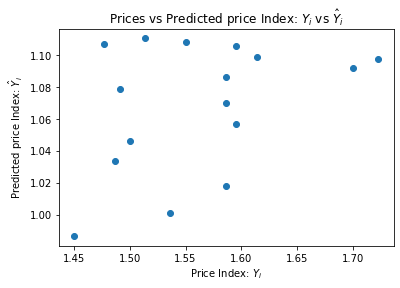

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")